<a href="https://colab.research.google.com/github/Jayaprakash1710/Computer-Vision-Ninjacart/blob/main/Ninjacart_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

File link: https://drive.google.com/file/d/1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT/view?usp=sharing

In [1]:
!gdown 1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT

Downloading...
From (original): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT
From (redirected): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT&confirm=t&uuid=76f2c8fa-bf60-4f30-9dcb-7a89d4e3b6cb
To: /content/ninjacart_data.zip
100% 275M/275M [00:05<00:00, 49.8MB/s]


In [2]:
!unzip /content/ninjacart_data.zip

Archive:  /content/ninjacart_data.zip
   creating: ninjacart_data/test/
   creating: ninjacart_data/test/indian market/
  inflating: ninjacart_data/test/indian market/bhl.jpeg  
  inflating: ninjacart_data/test/indian market/bhv.jpeg  
  inflating: ninjacart_data/test/indian market/bn.jpeg  
  inflating: ninjacart_data/test/indian market/hjx.jpeg  
  inflating: ninjacart_data/test/indian market/igis.jpeg  
  inflating: ninjacart_data/test/indian market/in.jpeg  
  inflating: ninjacart_data/test/indian market/india-4898453__340.jpg  
  inflating: ninjacart_data/test/indian market/indianmarket10.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket12.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket13.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket14.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket15.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket18.jpeg  
  inflating: ninjacart_data/test/indian market/

In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
import shutil
import random
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score

%matplotlib inline

In [4]:
def visualize_image_counts(dataset_type='train'):
    base_path = '/content/ninjacart_data'
    folder_path = os.path.join(base_path, dataset_type)
    class_counts = {}

    for class_name in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, class_name)
        if os.path.isdir(class_dir):
            count = len(os.listdir(class_dir))
            class_counts[class_name] = count

    total_images = sum(class_counts.values())

    # Plotting
    plt.figure(figsize=(8, 6))
    bars = plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.title(f"Image Count per Class in {dataset_type.capitalize()} Set")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height),
                 ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Print class-wise and total count below the plot
    print("\nClass-wise counts:")
    for cls, count in class_counts.items():
        print(f"{cls} - {count}")
    print(f"Total {dataset_type} images - {total_images}")

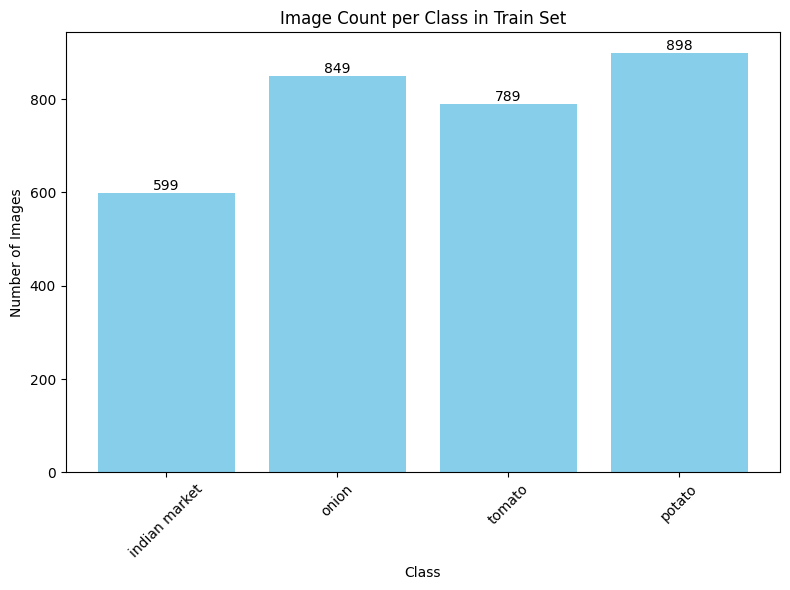


Class-wise counts:
indian market - 599
onion - 849
tomato - 789
potato - 898
Total train images - 3135


In [5]:
visualize_image_counts('train')

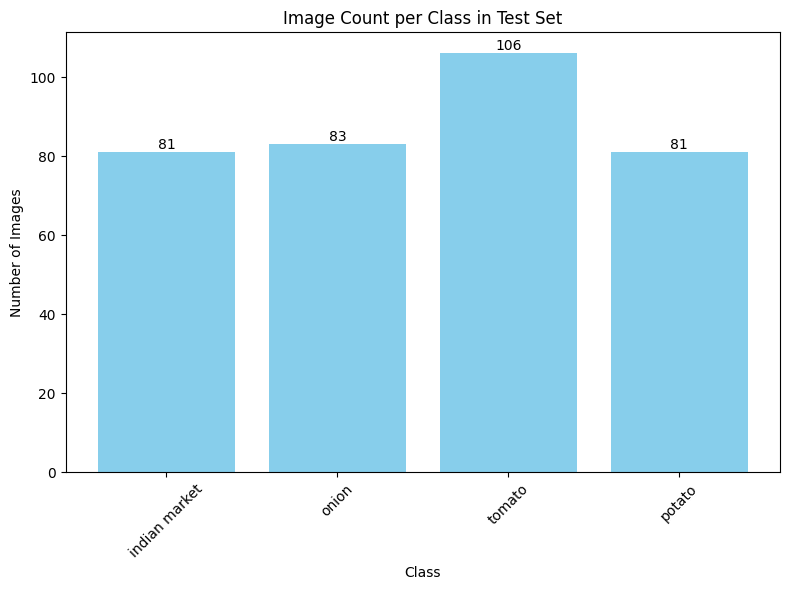


Class-wise counts:
indian market - 81
onion - 83
tomato - 106
potato - 81
Total test images - 351


In [6]:
visualize_image_counts("test")

In [7]:
def create_validation_split(train_dir='/content/ninjacart_data/train', val_dir='/content/ninjacart_data/val', val_split=0.15):
    os.makedirs(val_dir, exist_ok=True)

    for class_name in os.listdir(train_dir):
        class_train_path = os.path.join(train_dir, class_name)
        class_val_path = os.path.join(val_dir, class_name)

        if not os.path.isdir(class_train_path):
            continue

        os.makedirs(class_val_path, exist_ok=True)

        images = os.listdir(class_train_path)
        random.shuffle(images)

        val_count = int(len(images) * val_split)
        val_images = images[:val_count]

        for img in val_images:
            src_path = os.path.join(class_train_path, img)
            dst_path = os.path.join(class_val_path, img)
            shutil.move(src_path, dst_path)

    print("Validation split created.")

In [8]:
create_validation_split()

Validation split created.


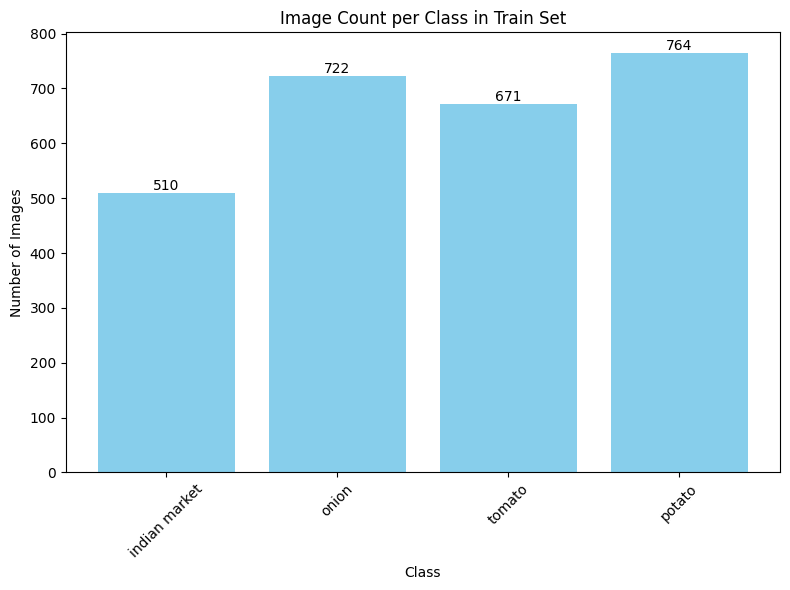


Class-wise counts:
indian market - 510
onion - 722
tomato - 671
potato - 764
Total train images - 2667


In [9]:
visualize_image_counts("train")

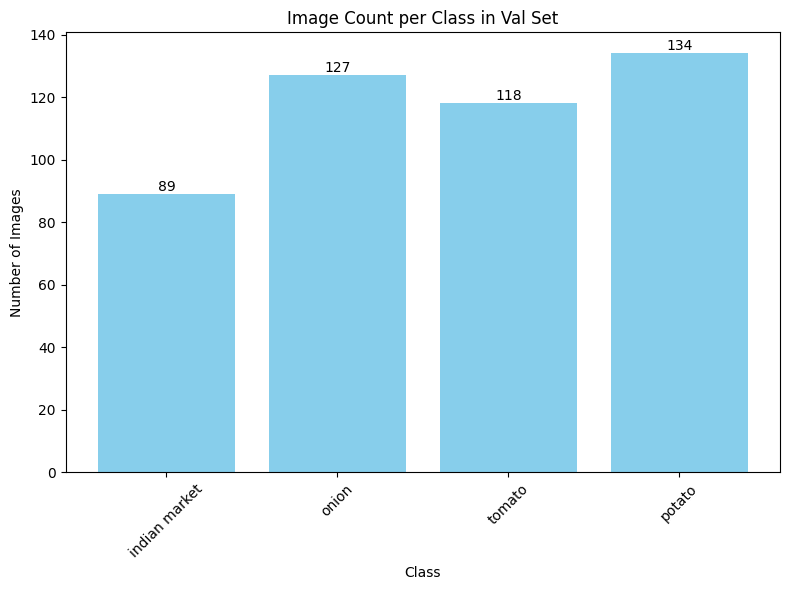


Class-wise counts:
indian market - 89
onion - 127
tomato - 118
potato - 134
Total val images - 468


In [10]:
visualize_image_counts("val")

In [11]:
def show_sample_images(train_dir='/content/ninjacart_data/train', samples_per_class=5):
    class_names = sorted(os.listdir(train_dir))
    plt.figure(figsize=(samples_per_class * 3, len(class_names) * 3))

    img_index = 1
    for class_name in class_names:
        class_path = os.path.join(train_dir, class_name)
        images = os.listdir(class_path)
        random.shuffle(images)
        images = images[:samples_per_class]

        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w, _ = img.shape

            plt.subplot(len(class_names), samples_per_class, img_index)
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.title(f"{class_name}\n{w}x{h}")
            img_index += 1

    plt.tight_layout()
    plt.show()

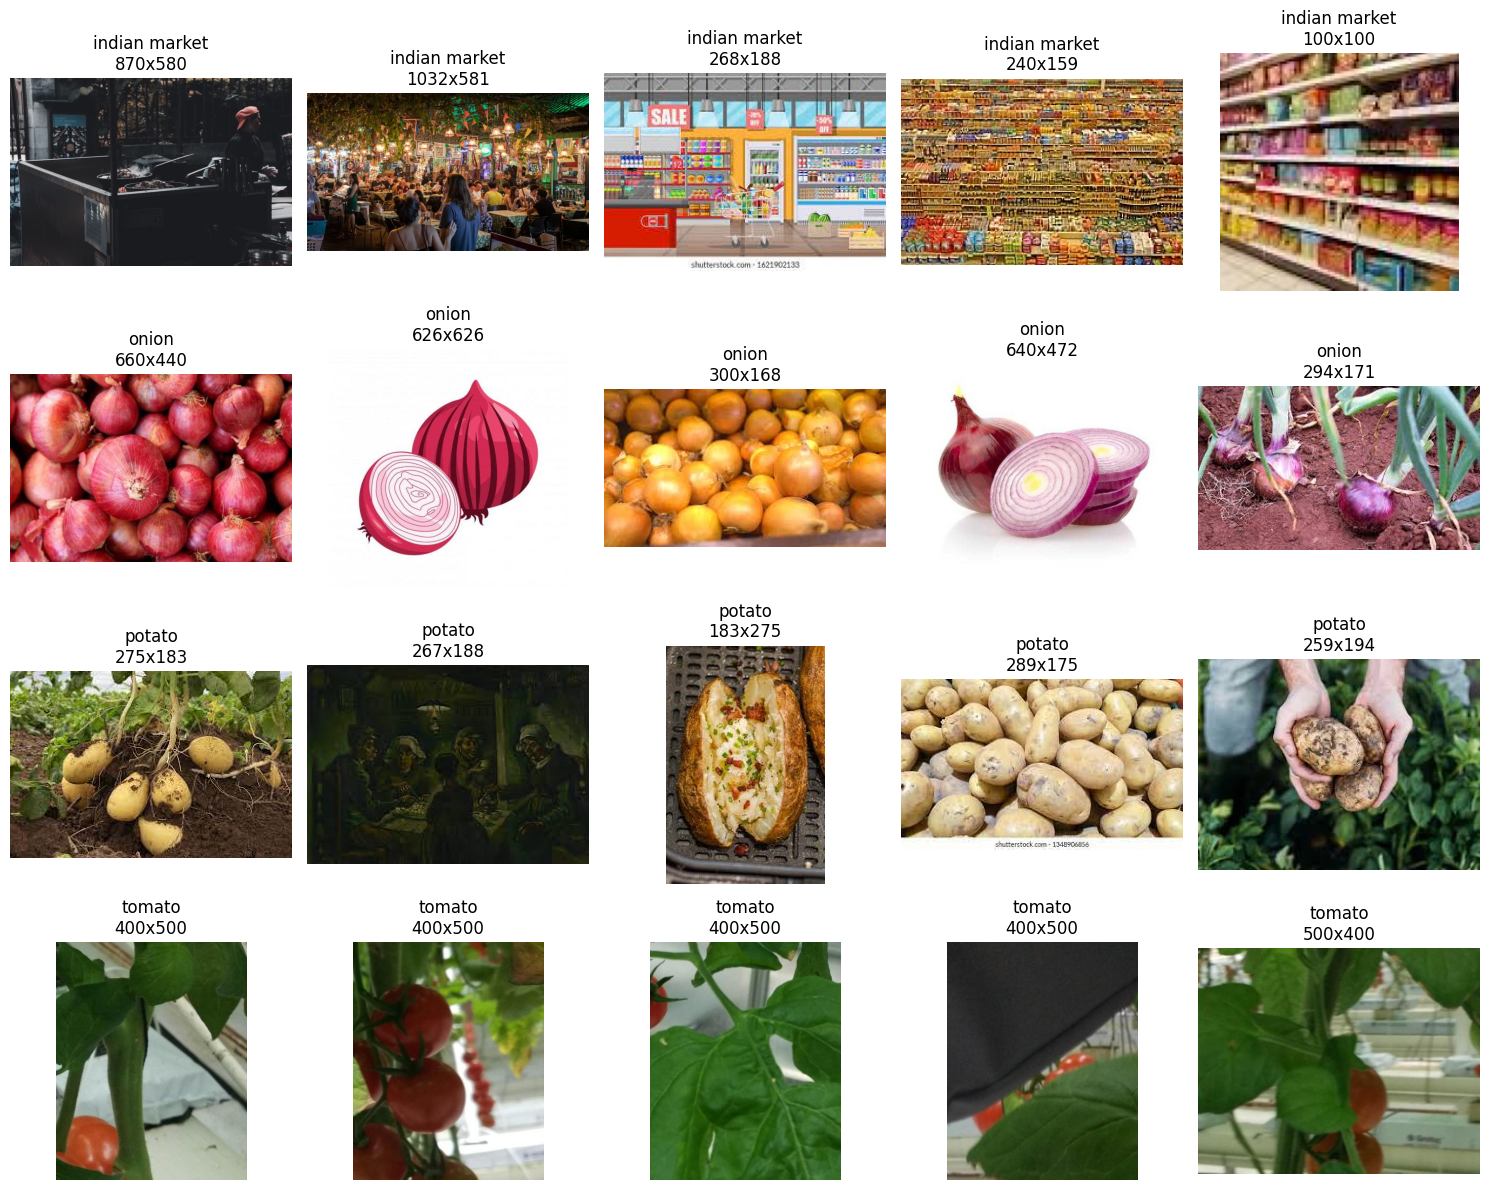

In [12]:
show_sample_images()

Loading the data into variables:

In [13]:
def load_data(base_dir="/content/ninjacart_data"):
    # checking if the data folders are present
    assert os.path.exists(f"{base_dir}/train") and os.path.exists(f"{base_dir}/val") and os.path.exists(f"{base_dir}/test")

    print('\nLoading Data...')
    train_data = tf.keras.utils.image_dataset_from_directory(
        f"{base_dir}/train", shuffle=True, label_mode='categorical'
    )
    val_data = tf.keras.utils.image_dataset_from_directory(
        f"{base_dir}/val", shuffle=False, label_mode='categorical'
    )
    test_data = tf.keras.utils.image_dataset_from_directory(
        f"{base_dir}/test", shuffle=False, label_mode='categorical'
    )
    return train_data, val_data, test_data, train_data.class_names

In [14]:
train_data, val_data, test_data, class_names = load_data()


Loading Data...
Found 2667 files belonging to 4 classes.
Found 468 files belonging to 4 classes.
Found 351 files belonging to 4 classes.


Resizing and Rescaling images:

In [15]:
def preprocess(train_data, val_data, test_data, target_height=224, target_width=224):

    # Data Processing Stage with resizing and rescaling operations
    data_preprocess = keras.Sequential(
        name="data_preprocess",
        layers=[
            layers.Resizing(target_height, target_width),
            layers.Rescaling(1.0/255),
        ]
    )

    # Perform Data Processing on the train, val, test dataset
    train_ds = train_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = preprocess(train_data, val_data, test_data)

#Base Line model

In [17]:
def baseline(height=224, width=224):
    num_classes = 4
    hidden_size = 256

    model = keras.Sequential(
        name="model_cnn",
        layers=[
            layers.Conv2D(filters=64, kernel_size=3, padding="same", activation='relu', input_shape=(height, width, 3)),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(units=hidden_size, activation='relu'),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [18]:
model = baseline()
model.summary()

Model: "model_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 802816)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │   205,521,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,523,972 (784.01 MB)

 Trainable params: 205,523,972 (784.01 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
def compile_train_v1(model, train_ds, val_ds, ckpt_path="/tmp/checkpoint.weights.h5"):
    epochs = 10
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[
        keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
    ])
    return model_fit

In [20]:
model_fit = compile_train_v1(model, train_ds, val_ds)

Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 55s 582ms/step - accuracy: 0.4663 - loss: 28.8266 - val_accuracy: 0.7457 - val_loss: 0.6368
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 91s 745ms/step - accuracy: 0.8206 - loss: 0.4928 - val_accuracy: 0.7778 - val_loss: 0.5598
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 66s 559ms/step - accuracy: 0.9335 - loss: 0.2288 - val_accuracy: 0.8248 - val_loss: 0.5096
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 45s 115ms/step - accuracy: 0.9682 - loss: 0.1359 - val_accuracy: 0.7906 - val_loss: 0.6696
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.9821 - loss: 0.0806 - val_accuracy: 0.8056 - val_loss: 0.7826
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.9883 - loss: 0.0515 - val_accuracy: 0.7692 - val_loss: 0.9715
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - accuracy: 0.9954 - loss: 0.0176 - val_accuracy: 0.8034 - val_loss: 0.8113
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.9965 - loss: 0.0154 - val_accu

In [21]:
def annot_max(x,y, xytext=(0.94,0.96), ax=None, only_y=True):
    xmax = x[np.argmax(y)]
    ymax = max(y)
    if only_y:
        text = "{:.2f}%".format(ymax)
    else:
        text= "x={:.2f}, y={:.2f}%".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=xytext, **kw)

def plot_accuracy(model_fit):
    #accuracy graph
    x = range(0,len(model_fit.history['accuracy']))
    y_train = [acc * 100 for acc in model_fit.history['accuracy']]
    y_val = [acc * 100 for acc in model_fit.history['val_accuracy']]

    plt.plot(x, y_train, label='Train', color='b')
    annot_max(x, y_train, xytext=(0.7,0.9))
    plt.plot(x, y_val, label='Val', color='r')
    annot_max(x, y_val, xytext=(0.8,0.7))
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()

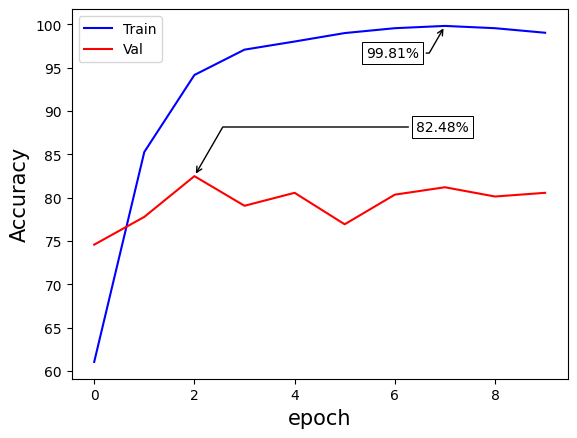

In [22]:
plot_accuracy(model_fit)

In [23]:
def print_accuracy_stats(model, ds, class_names):
    model.load_weights("/tmp/checkpoint.weights.h5")
    true_onehot = tf.concat([y for x, y in ds], axis=0)
    true_categories = tf.argmax(true_onehot, axis=1)
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)

    test_acc = accuracy_score(true_categories, predicted_categories) * 100
    print(f'\nTest Accuracy: {test_acc:.2f}%\n')

# Note: This doesn't work with shuffled datasets
def plot_confusion_matrix(model, ds, class_names):
    model.load_weights("/tmp/checkpoint.weights.h5")
    true_onehot = tf.concat([y for x, y in ds], axis=0)
    true_categories = tf.argmax(true_onehot, axis=1)
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)
    cm = confusion_matrix(true_categories,predicted_categories) # last batch
    sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, cmap="YlGnBu", fmt='g')
    plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step

Test Accuracy: 76.35%

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


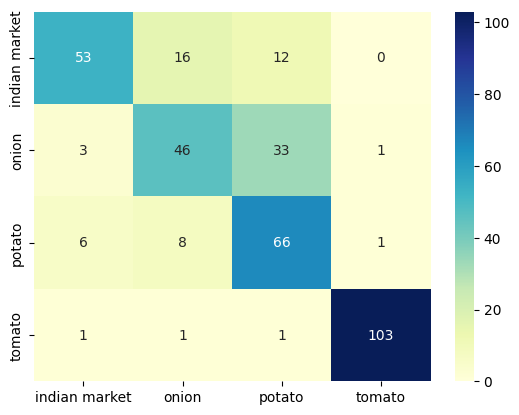

In [24]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# Architecture-1

In [25]:
def arch_1(height=224, width=224):
    num_classes = 4
    hidden_size = 512

    model = keras.Sequential(
        name="model_cnn_1",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", activation='relu', input_shape=(height, width, 3)),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=32, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=64, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=128, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=256, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=512, kernel_size=3, padding="same", activation='relu'),
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size, activation='relu'),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [26]:
model = arch_1()
model.summary()

Model: "model_cnn_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,837,476 (7.01 MB)

 Trainable params: 1,837,476 (7.01 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
def compile_train_v1(model, train_ds, val_ds, epochs=10, ckpt_path="/tmp/checkpoint.weights.h5"):
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[
        keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
    ])
    return model_fit

In [28]:
model_fit = compile_train_v1(model, train_ds, val_ds)

Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - accuracy: 0.3912 - loss: 1.2961 - val_accuracy: 0.6453 - val_loss: 0.8091
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.6471 - loss: 0.7616 - val_accuracy: 0.7650 - val_loss: 0.5621
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.7326 - loss: 0.6488 - val_accuracy: 0.7970 - val_loss: 0.5047
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.7991 - loss: 0.5323 - val_accuracy: 0.7991 - val_loss: 0.5069
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.7999 - loss: 0.5522 - val_accuracy: 0.8462 - val_loss: 0.4181
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.8326 - loss: 0.4355 - val_accuracy: 0.8440 - val_loss: 0.4057
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.8420 - loss: 0.4217 - val_accuracy: 0.8718 - val_loss: 0.3244
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.8465 - loss: 0.4115 - val_accurac

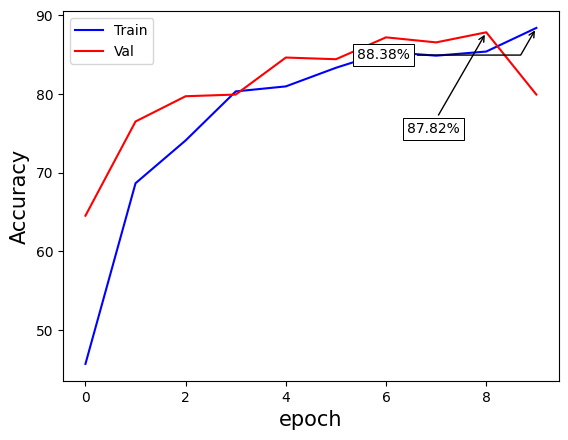

In [29]:
plot_accuracy(model_fit)

In [30]:
model_fit = compile_train_v1(model, train_ds, val_ds, epochs=30)

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - accuracy: 0.8601 - loss: 0.3733 - val_accuracy: 0.8846 - val_loss: 0.3076
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 0.8721 - loss: 0.3359 - val_accuracy: 0.8761 - val_loss: 0.3104
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.8659 - loss: 0.3381 - val_accuracy: 0.8697 - val_loss: 0.3165
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.8801 - loss: 0.3150 - val_accuracy: 0.8910 - val_loss: 0.2504
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.8940 - loss: 0.2556 - val_accuracy: 0.8226 - val_loss: 0.4299
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.8959 - loss: 0.2641 - val_accuracy: 0.8846 - val_loss: 0.2823
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.8936 - loss: 0.2512 - val_accuracy: 0.8547 - val_loss: 0.3005
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.8988 - loss: 0.2633 - val_accuracy

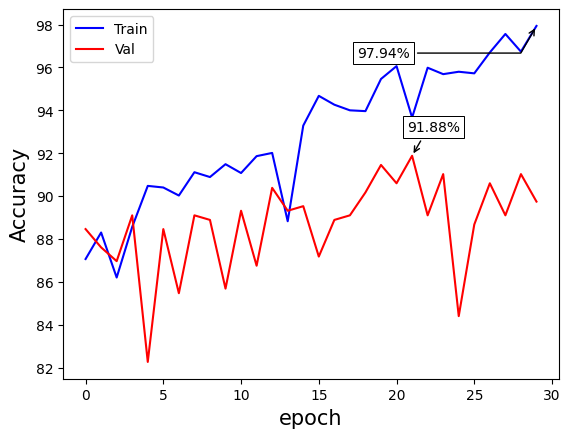

In [31]:
plot_accuracy(model_fit)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step

Test Accuracy: 91.17%

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


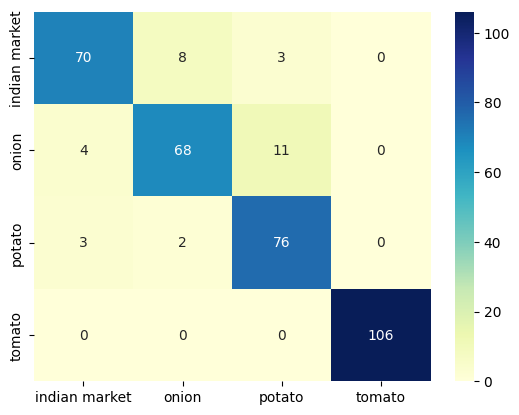

In [32]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# Architecture-2

In [33]:
def arch_2(height=224, width=224):
    num_classes = 4
    hidden_size = 512

    model = keras.Sequential(
        name="model_cnn_2",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", input_shape=(height, width, 3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=32, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=64, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=128, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=256, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=512, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [34]:
model = arch_2()
model.summary()

Model: "model_cnn_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,843,556 (7.03 MB)

 Trainable params: 1,840,516 (7.02 MB)

 Non-trainable params: 3,040 (11.88 KB)

In [35]:
model_fit = compile_train_v1(model, train_ds, val_ds, epochs=30)

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 23s 168ms/step - accuracy: 0.6704 - loss: 1.0887 - val_accuracy: 0.2949 - val_loss: 3.6910
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.7707 - loss: 0.6479 - val_accuracy: 0.3248 - val_loss: 2.4041
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.8102 - loss: 0.5237 - val_accuracy: 0.4872 - val_loss: 2.3934
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.8098 - loss: 0.4856 - val_accuracy: 0.5962 - val_loss: 1.2151
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.8464 - loss: 0.4008 - val_accuracy: 0.6645 - val_loss: 0.8663
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.8491 - loss: 0.3918 - val_accuracy: 0.7692 - val_loss: 0.6608
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.8543 - loss: 0.3813 - val_accuracy: 0.7735 - val_loss: 0.4663
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.8543 - loss: 0.3924 - val_accur

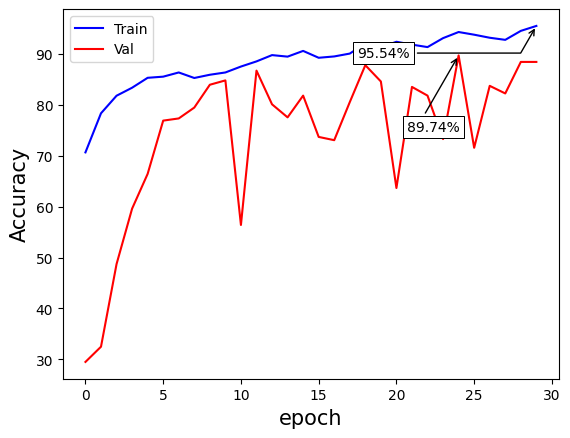

In [36]:
plot_accuracy(model_fit)

In [37]:
def compile_train_v2(model, train_ds, val_ds, epochs=10, ckpt_path="/tmp/checkpoint.weights.h5"):
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.3, patience=10, min_lr=0.00001
        ),
        keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, min_delta=0.001, mode='min'
        )
    ]
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)
    return model_fit

In [38]:
model = arch_2()
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=100)

Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 24s 163ms/step - accuracy: 0.6708 - loss: 1.1447 - val_accuracy: 0.2308 - val_loss: 2.1137 - learning_rate: 0.0010
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.7778 - loss: 0.5976 - val_accuracy: 0.3526 - val_loss: 2.5562 - learning_rate: 0.0010
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.7996 - loss: 0.5782 - val_accuracy: 0.4103 - val_loss: 2.2361 - learning_rate: 0.0010
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.8119 - loss: 0.5329 - val_accuracy: 0.3803 - val_loss: 2.8650 - learning_rate: 0.0010
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.8250 - loss: 0.4598 - val_accuracy: 0.6026 - val_loss: 1.2562 - learning_rate: 0.0010
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.8376 - loss: 0.4306 - val_accuracy: 0.6987 - val_loss: 0.8007 - learning_rate: 0.0010
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.8743 - loss

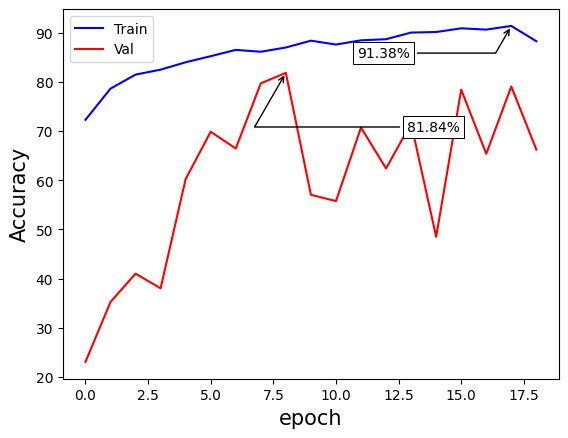

In [39]:
plot_accuracy(model_fit)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step

Test Accuracy: 78.06%

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


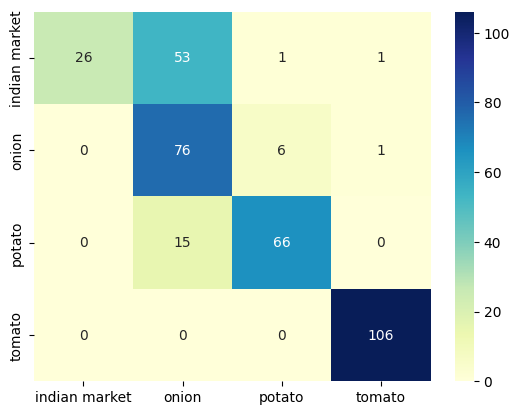

In [40]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# Architecture-3

In [41]:
def arch_3(height=224, width=224):
    num_classes = 4
    hidden_size = 256

    model = keras.Sequential(
        name="model_cnn_3",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", input_shape=(height, width, 3),
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=32, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=64, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=128, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=256, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            # layers.MaxPooling2D(),
            # layers.Flatten(),
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size, kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [42]:
model = arch_3()
model.summary()

Model: "model_cnn_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 256)            │             

 Total params: 462,436 (1.76 MB)

 Trainable params: 460,932 (1.76 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [43]:
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=100)

Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 24s 181ms/step - accuracy: 0.6654 - loss: 1.5969 - val_accuracy: 0.2671 - val_loss: 2.7075 - learning_rate: 0.0010
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.7449 - loss: 1.2950 - val_accuracy: 0.2521 - val_loss: 5.3403 - learning_rate: 0.0010
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.8115 - loss: 1.0743 - val_accuracy: 0.4701 - val_loss: 1.7532 - learning_rate: 0.0010
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.8051 - loss: 1.0372 - val_accuracy: 0.4145 - val_loss: 2.8929 - learning_rate: 0.0010
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.8256 - loss: 0.9718 - val_accuracy: 0.5876 - val_loss: 1.4042 - learning_rate: 0.0010
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - accuracy: 0.8312 - loss: 0.9343 - val_accuracy: 0.7650 - val_loss: 1.0878 - learning_rate: 0.0010
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.8499 - loss: 

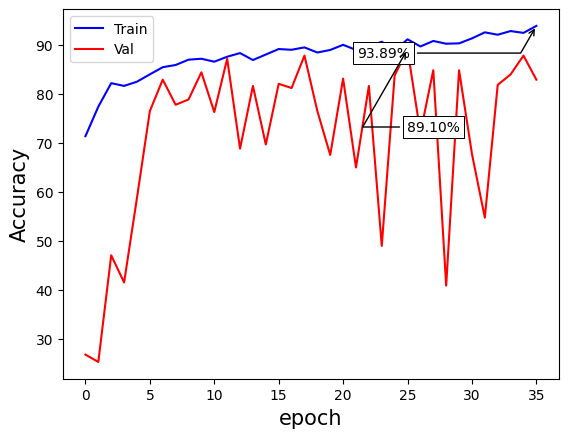

In [44]:
plot_accuracy(model_fit)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step

Test Accuracy: 83.76%

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


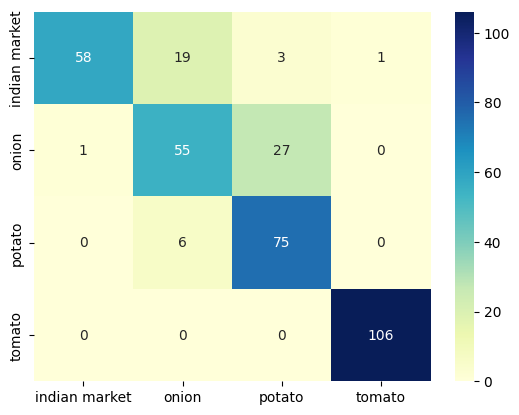

In [45]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# Data Augmentation

In [59]:
def get_augmented_train_ds(path, img_size=(224, 224), batch_size=32):
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.05),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomContrast(0.1),
        #tf.keras.layers.RandomBrightness(0.2),
        tf.keras.layers.RandomTranslation(0.05, 0.05),
        #tf.keras.layers.RandomCrop(img_size[0], img_size[1])
    ])

    raw_train_ds = tf.keras.utils.image_dataset_from_directory(
        path,
        image_size=img_size,
        batch_size=batch_size
    )

    class_names = raw_train_ds.class_names
    num_classes = len(class_names)

    # Apply augmentation + one-hot + performance tweaks
    augmented_train_ds = raw_train_ds.map(
        lambda x, y: (data_augmentation(x), tf.one_hot(y, depth=num_classes)),
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)

    return augmented_train_ds, class_names

In [60]:
train_ds, class_names = get_augmented_train_ds('/content/ninjacart_data/train')

Found 2667 files belonging to 4 classes.


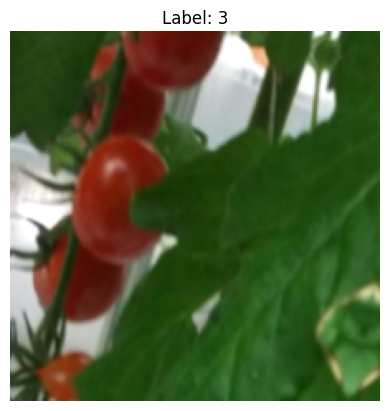

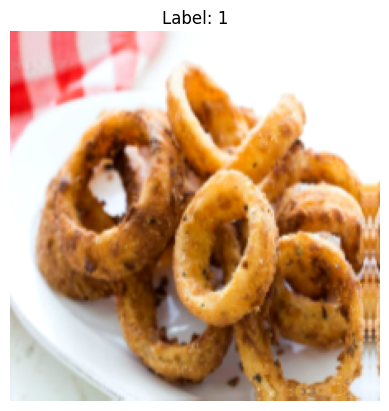

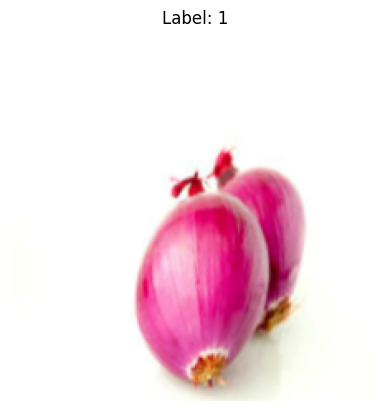

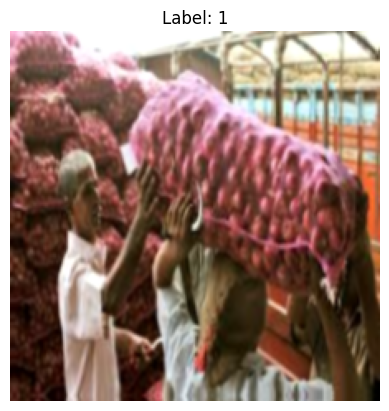

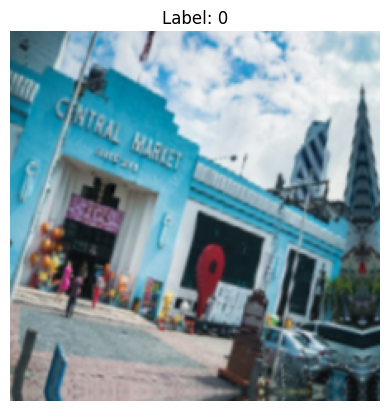

In [61]:
for images, labels in train_ds.take(1):
    for i in range(5):
        plt.imshow(images[i].numpy())
        plt.title(f"Label: {tf.argmax(labels[i]).numpy()}")
        plt.axis('off')
        plt.show()

In [62]:
model = arch_3()
model.summary()

Model: "model_cnn_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 256)            │             

 Total params: 462,436 (1.76 MB)

 Trainable params: 460,932 (1.76 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [63]:
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=100)

Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 55s 542ms/step - accuracy: 0.6729 - loss: 1.6520 - val_accuracy: 0.2543 - val_loss: 2.4449 - learning_rate: 0.0010
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 40s 467ms/step - accuracy: 0.7767 - loss: 1.2339 - val_accuracy: 0.2521 - val_loss: 5.7034 - learning_rate: 0.0010
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 39s 461ms/step - accuracy: 0.7792 - loss: 1.1174 - val_accuracy: 0.5769 - val_loss: 1.9082 - learning_rate: 0.0010
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 463ms/step - accuracy: 0.8142 - loss: 1.0072 - val_accuracy: 0.2949 - val_loss: 4.7550 - learning_rate: 0.0010
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 42s 476ms/step - accuracy: 0.8243 - loss: 0.9648 - val_accuracy: 0.5705 - val_loss: 1.9370 - learning_rate: 0.0010
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 80s 462ms/step - accuracy: 0.8540 - loss: 0.8738 - val_accuracy: 0.7179 - val_loss: 1.2387 - learning_rate: 0.0010
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 42s 471ms/step - accuracy: 0.8412 - l

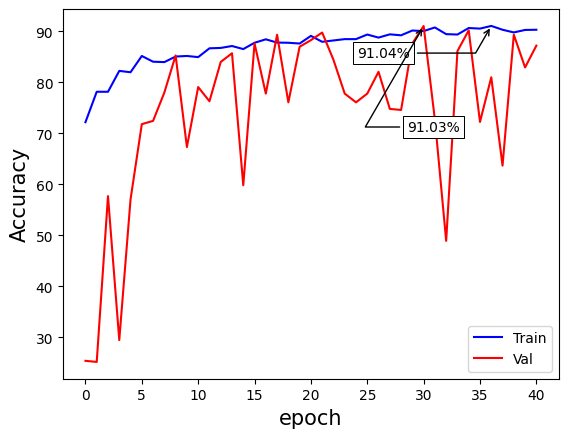

In [64]:
plot_accuracy(model_fit)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step

Test Accuracy: 84.33%

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step


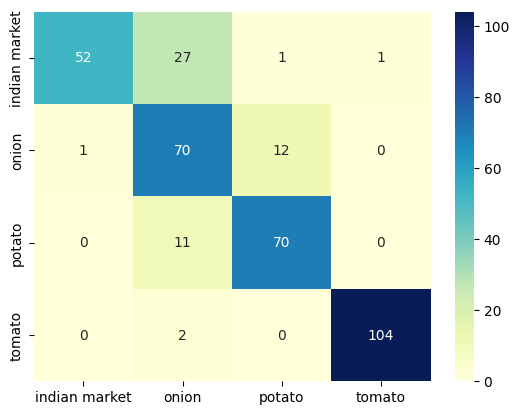

In [65]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# Vgg-16

In [46]:
pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=[224,224, 3])
pretrained_model.trainable=False
vgg16_model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='softmax')
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [47]:
model=vgg16_model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4)              │       100,356 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,815,044 (56.51 MB)

 Trainable params: 100,356 (392.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [48]:
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=100)

Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 53s 494ms/step - accuracy: 0.6777 - loss: 0.8176 - val_accuracy: 0.8825 - val_loss: 0.2787 - learning_rate: 0.0010
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 17s 206ms/step - accuracy: 0.9507 - loss: 0.1419 - val_accuracy: 0.9081 - val_loss: 0.2365 - learning_rate: 0.0010
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 236ms/step - accuracy: 0.9825 - loss: 0.0632 - val_accuracy: 0.8996 - val_loss: 0.2349 - learning_rate: 0.0010
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 17s 205ms/step - accuracy: 0.9952 - loss: 0.0359 - val_accuracy: 0.9167 - val_loss: 0.2307 - learning_rate: 0.0010
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 18s 208ms/step - accuracy: 0.9998 - loss: 0.0189 - val_accuracy: 0.9274 - val_loss: 0.2243 - learning_rate: 0.0010
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 23s 236ms/step - accuracy: 1.0000 - loss: 0.0143 - val_accuracy: 0.9295 - val_loss: 0.2240 - learning_rate: 0.0010
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 235ms/step - accuracy: 0.9998 - l

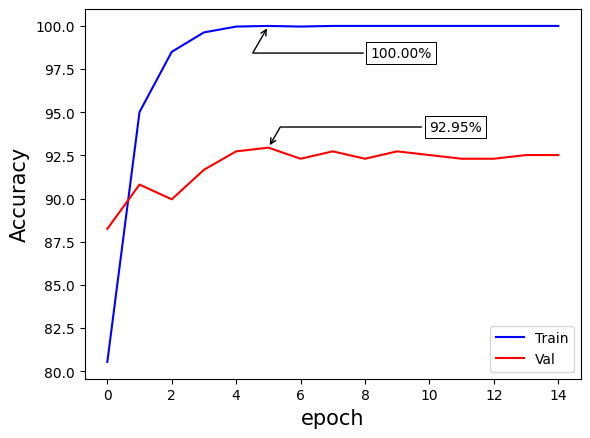

In [49]:
plot_accuracy(model_fit)

11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step

Test Accuracy: 85.75%

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step


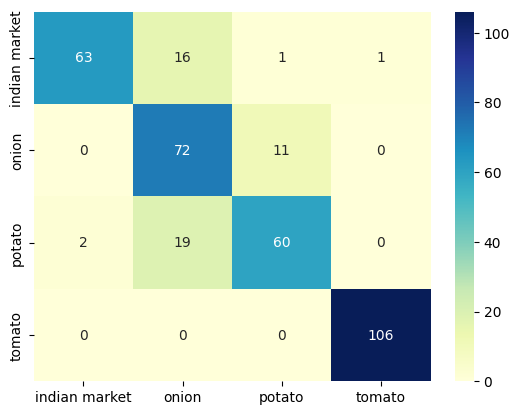

In [50]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# ResNet 50

In [51]:
pretrained_resnet = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
pretrained_resnet.trainable = False

resnet_model = tf.keras.Sequential([
    pretrained_resnet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='softmax')
])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [52]:
model=resnet_model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │       401,412 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,989,124 (91.51 MB)

 Trainable params: 401,412 (1.53 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [53]:
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=100)

Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 37s 293ms/step - accuracy: 0.3491 - loss: 3.9097 - val_accuracy: 0.4487 - val_loss: 1.2095 - learning_rate: 0.0010
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.5180 - loss: 1.2947 - val_accuracy: 0.3953 - val_loss: 2.2104 - learning_rate: 0.0010
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - accuracy: 0.5718 - loss: 1.1511 - val_accuracy: 0.6453 - val_loss: 0.8808 - learning_rate: 0.0010
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.6667 - loss: 0.8053 - val_accuracy: 0.6368 - val_loss: 0.8539 - learning_rate: 0.0010
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.6932 - loss: 0.7332 - val_accuracy: 0.6410 - val_loss: 0.8329 - learning_rate: 0.0010
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.6974 - loss: 0.7306 - val_accuracy: 0.4829 - val_loss: 1.8137 - learning_rate: 0.0010
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.6076 - l

11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 709ms/step

Test Accuracy: 72.65%

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step


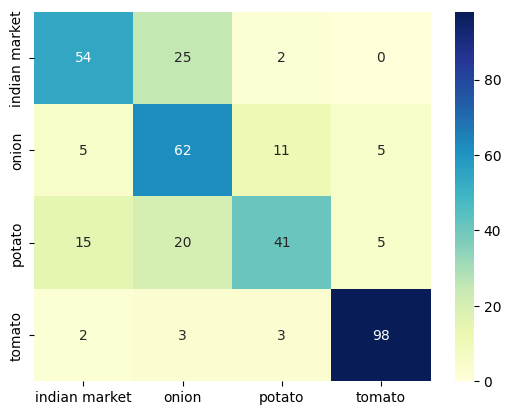

In [54]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# MobileNet V2

In [55]:
pretrained_mobilenet = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
pretrained_mobilenet.trainable = False

mobilenet_model = tf.keras.Sequential([
    pretrained_mobilenet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [56]:
model=mobilenet_model
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4)              │       250,884 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,508,868 (9.57 MB)

 Trainable params: 250,884 (980.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [57]:
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=100)

Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 27s 216ms/step - accuracy: 0.8164 - loss: 1.5765 - val_accuracy: 0.9594 - val_loss: 0.2235 - learning_rate: 0.0010
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.9807 - loss: 0.1762 - val_accuracy: 0.9701 - val_loss: 0.3458 - learning_rate: 0.0010
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.9925 - loss: 0.0611 - val_accuracy: 0.9594 - val_loss: 0.5980 - learning_rate: 0.0010
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.9943 - loss: 0.0305 - val_accuracy: 0.9573 - val_loss: 0.7106 - learning_rate: 0.0010
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.9974 - loss: 0.0274 - val_accuracy: 0.9765 - val_loss: 0.3670 - learning_rate: 0.0010
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 1.0000 - loss: 3.5338e-05 - val_accuracy: 0.9765 - val_loss: 0.3664 - learning_rate: 0.0010
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.9998 

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 636ms/step

Test Accuracy: 88.32%

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


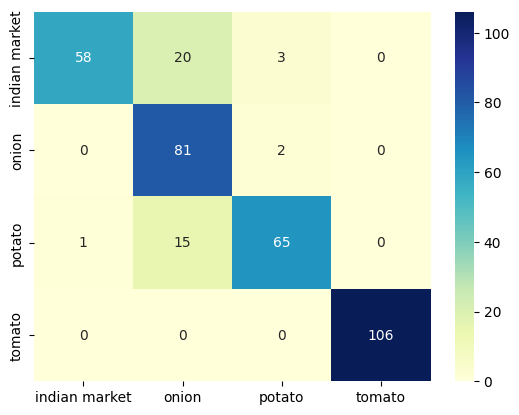

In [58]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)